In [51]:
import os
import site
import sqlite3
import sys
import warnings
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from yaml import dump, load, safe_load

In [2]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [3]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [4]:
sys.path.append("../../sql")
import queries

In [5]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [6]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [7]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [33]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time, year, zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
Wind_Speed,
Wind_Direction
from nsrdb
where zipcode = :zipcode;
"""


df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)

In [34]:
df  # .head(5)

,year,zipcode,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
date_time,,,,,,,,,,,
1998-01-01 00:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,65.10,1.548,1.0,86.7
1998-01-01 01:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,61.26,1.468,1.0,83.5
1998-01-01 02:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,58.23,1.405,1.0,83.3
1998-01-01 03:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,56.02,1.367,1.1,85.0
1998-01-01 04:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,53.99,1.361,1.1,87.7
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:30:00,2020,91708,0.0,0.0,0.0,0.0,8.9,59.76,0.800,1.4,43.0
2020-12-31 20:30:00,2020,91708,0.0,0.0,0.0,0.0,8.2,60.02,0.800,1.5,47.0
2020-12-31 21:30:00,2020,91708,0.0,0.0,0.0,0.0,7.6,60.17,0.800,1.5,49.0


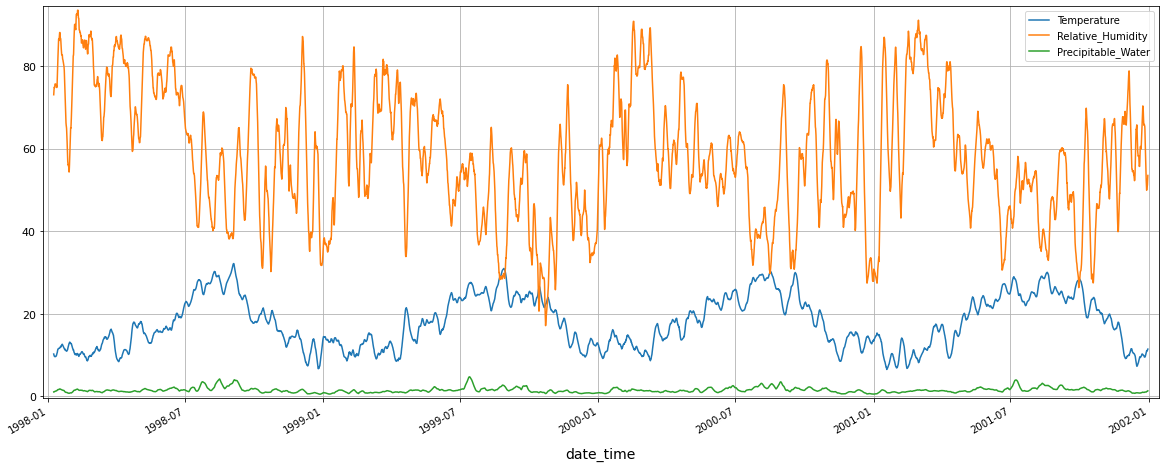

In [10]:
# # compares = ["Clearsky_DHI", "DHI"]
# compares = ["Wind_Speed", "Wind_Direction"]
compares = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
# compares = ["Clearsky_GHI", "GHI"]
# compares = ["Clearsky_DNI", "DNI"]

df.iloc[:35040][compares].rolling(168).mean().plot(figsize=(20, 8))
plt.grid()

In [11]:
df_rsm = df.resample("M").mean().reset_index(drop=False)

In [12]:
df_rsm

,date_time,year,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
0,1998-01-31,1998.0,312.725806,193.256720,158.559140,116.268817,11.461022,74.901344,1.196043,1.408737,168.557661
1,1998-02-28,1998.0,330.165179,171.066964,201.436012,136.398810,10.007440,86.479226,1.425155,2.150149,200.181101
2,1998-03-31,1998.0,365.642473,219.232527,261.442204,187.193548,12.858871,76.266237,1.270946,1.910887,182.766129
3,1998-04-30,1998.0,384.641667,292.604167,313.873611,268.347222,13.668056,72.995972,1.137753,1.906944,195.900833
4,1998-05-31,1998.0,399.022849,244.490591,345.922043,257.693548,14.939516,79.635323,1.470833,2.055242,212.420430
...,...,...,...,...,...,...,...,...,...,...,...
271,2020-08-31,2020.0,372.713710,356.186828,313.321237,307.096774,29.165591,35.584583,2.411290,1.757930,194.243280
272,2020-09-30,2020.0,285.506944,277.145833,255.193056,250.990278,28.539306,27.949014,1.710972,1.436528,156.625000
273,2020-10-31,2020.0,329.411290,280.205645,217.068548,195.552419,23.991935,36.020228,1.315323,1.522446,158.978495
274,2020-11-30,2020.0,324.305556,292.790278,170.163889,160.405556,16.961389,40.650194,1.097222,1.663889,133.398611


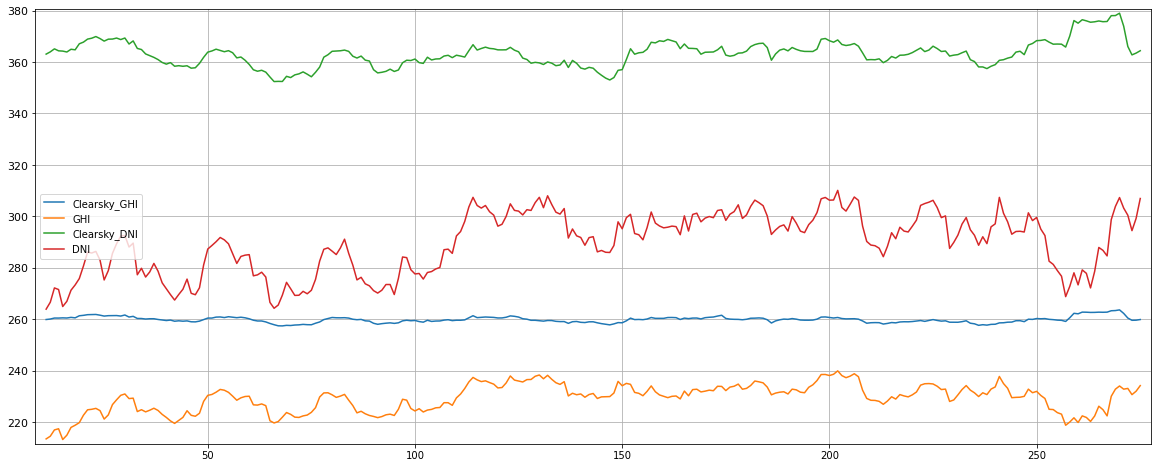

In [13]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_G = ["Clearsky_GHI", "GHI"]
compares_D = ["Clearsky_DNI", "DNI"]
compares_A = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_rsm[compares_G + compares_D].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [37]:
columns = df_rsm.columns.tolist()
columns = columns[2:]
print(columns)

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed', 'Wind_Direction']


In [38]:
adf_tests = []

for col in columns:
    adf_tests.append(adfuller(df_rsm[col], autolag="AIC"))

for col, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]} for {col}")

p-value: 0.013929405390809384 for Clearsky_DNI
p-value: 0.02967029752899351 for DNI
p-value: 0.007493200915726942 for Clearsky_GHI
p-value: 0.007490254789246983 for GHI
p-value: 0.09761117603524261 for Temperature
p-value: 0.007031148782455697 for Relative_Humidity
p-value: 0.006931830187666589 for Precipitable_Water
p-value: 0.00739791978213566 for Wind_Speed
p-value: 0.08651566119406462 for Wind_Direction


In [39]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in columns:
        kpss_tests.append(kpss(df_rsm[col], regression="ct", nlags="auto"))

for col, test in zip(cols, kpss_tests):
    print(f"p-value: {test[1]} for {col}")

p-value: 0.1 for Clearsky_DNI
p-value: 0.1 for DNI
p-value: 0.1 for Clearsky_GHI
p-value: 0.1 for GHI
p-value: 0.1 for Temperature
p-value: 0.1 for Relative_Humidity
p-value: 0.1 for Precipitable_Water
p-value: 0.1 for Wind_Speed
p-value: 0.1 for Wind_Direction


In [42]:
def plot_autocorr(df, columns, column_idx, max_lag):

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    ax = ax.flatten()

    for idx, col in enumerate(column_idx):
        plot_acf(
            df_rsm[columns[col]],
            ax[idx],
            lags=max_lag,
            title=f"{columns[col]} Autocorrelation",
        )
        ax[idx].set_xlabel(r"Lag")
        ax[idx].set_ylabel(r"Correlation")

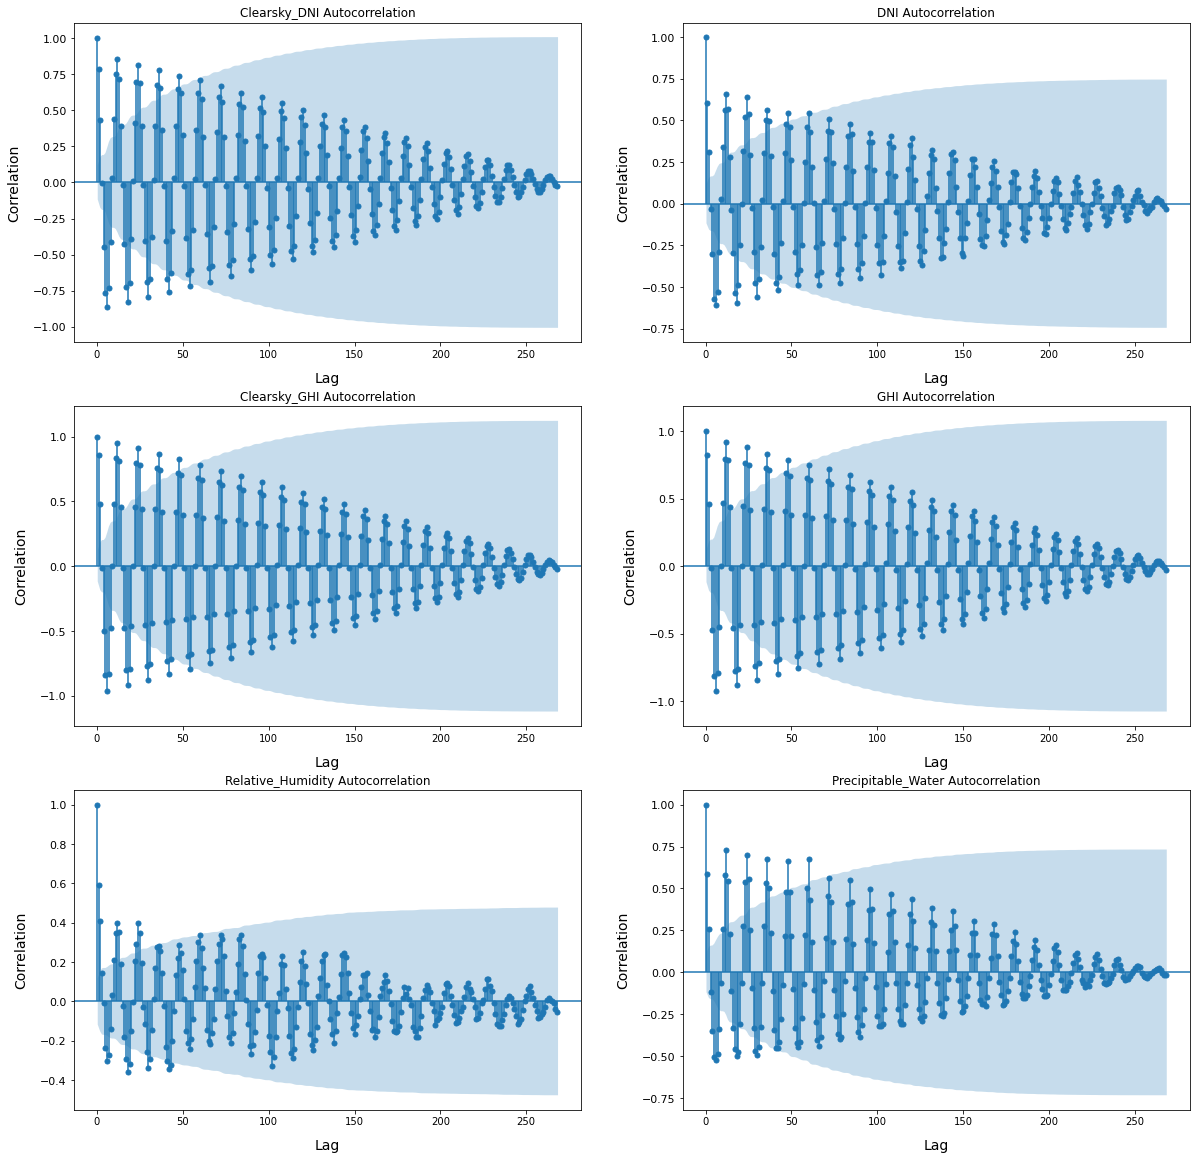

In [43]:
plot_autocorr(df_rsm, columns, [0, 1, 2, 3, 5, 6], 268)

In [71]:
df_r = df_rsm[:264]

In [94]:
df_r

,date_time,year,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
0,1998-01-31,1998.0,312.725806,193.256720,158.559140,116.268817,11.461022,74.901344,1.196043,1.408737,168.557661
1,1998-02-28,1998.0,330.165179,171.066964,201.436012,136.398810,10.007440,86.479226,1.425155,2.150149,200.181101
2,1998-03-31,1998.0,365.642473,219.232527,261.442204,187.193548,12.858871,76.266237,1.270946,1.910887,182.766129
3,1998-04-30,1998.0,384.641667,292.604167,313.873611,268.347222,13.668056,72.995972,1.137753,1.906944,195.900833
4,1998-05-31,1998.0,399.022849,244.490591,345.922043,257.693548,14.939516,79.635323,1.470833,2.055242,212.420430
...,...,...,...,...,...,...,...,...,...,...,...
259,2019-08-31,2019.0,433.250000,405.340054,329.735215,321.919355,27.866129,29.611613,1.717339,1.611156,179.916667
260,2019-09-30,2019.0,380.225000,310.533333,276.845833,247.556944,25.482917,43.078792,2.002083,1.740833,187.444444
261,2019-10-31,2019.0,368.690860,352.060484,227.563172,224.592742,21.193011,30.852984,0.905914,1.952419,134.368280
262,2019-11-30,2019.0,315.977778,235.525000,169.654167,144.323611,17.724028,39.121639,1.199583,1.543056,129.741667


In [102]:
def arima_forecast(series, num_forecasts, p=0, d=0, q=0):
    """
    Takes an irradiance related series and fits an ARMA(p, q) model.
    Returns a number of forecasts as specified by num_forecasts.
    """

    start = len(series)
    end = start + num_forecasts - 1

    # model = ARIMA(series, order=(p, d, p), enforce_stationarity=True, trend="n")
    model = ARIMA(series, order=(p, d, p), enforce_stationarity=True, trend="n")

    result = model.fit()

    forecasts = result.predict(start=start, end=end)

    return forecasts

In [109]:
forecasts = arima_forecast(df_r[columns[0]], 12, p=0, d=1, q=0)
# forecasts

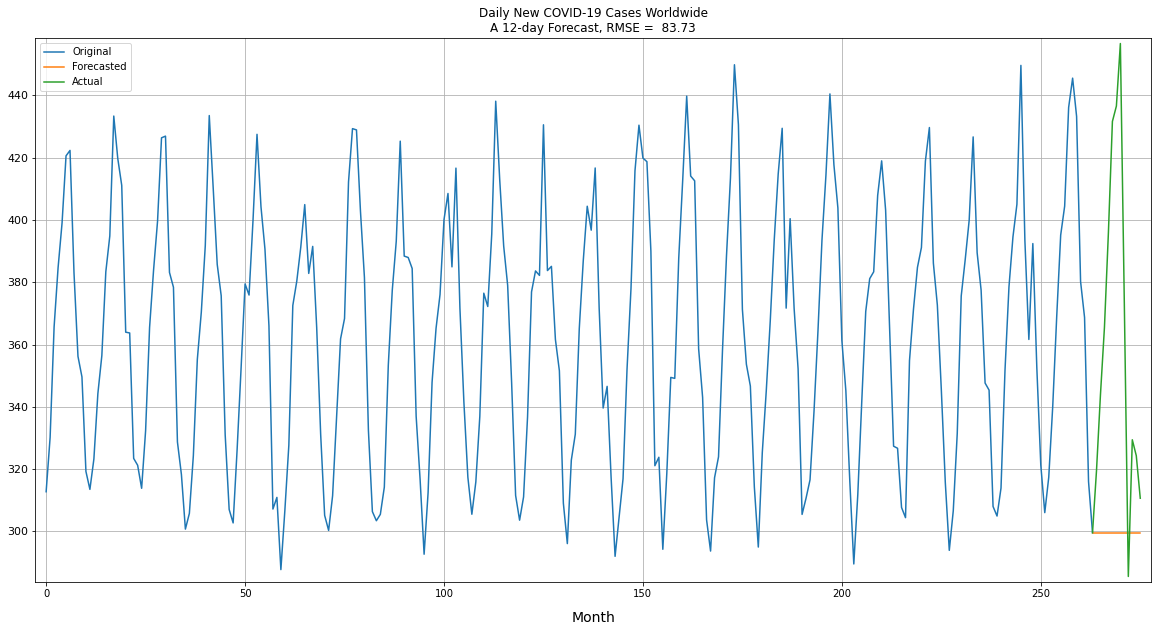

In [110]:
actual = df_rsm[columns[0]][264:]

rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_r[columns[0]], label="Original")
ax.plot(df_r[columns[0]][-1:].append(forecasts), label="Forecasted")
ax.plot(df_r[columns[0]][-1:].append(actual), label="Actual")

ax.set_xlabel("Month")

ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")

ax.grid()
ax.legend();